<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimization - XY Layout
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

In [1]:
#%%capture
#!pip install wandb --upgrade --quiet

In [2]:
import wandb

wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sazio (use `wandb login --relogin` to force relogin)


True

## Loading of Stringer spontaneous data



In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [6]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [7]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [8]:
resp = np.array(dat['sresp'])
xyz = np.array(dat['xyz'])
print(resp.shape, xyz[0].shape)

(11983, 7018) (11983,)


In [9]:
# Extracting x,y blocks

n_blocks = 9

x_range, y_range, _ = np.ptp(dat['xyz'], axis = 1)

x_block_starts = np.arange(min(x), max(x), x_range // (n_blocks ** 0.5))
y_block_starts = np.arange(min(y), max(y), y_range // (n_blocks ** 0.5))

data_blocks = list()

for i in range(int(n_blocks ** 0.5)):
    for k in range(int(n_blocks ** 0.5)):
        tempx, = np.where((x >= x_block_starts[0]) & (x <= x_block_starts[1]))
        tempy, = np.where((y >= y_block_starts[0]) & (y <= y_block_starts[1]))
        idx = np.intersect1d(tempx, tempy)
        data_blocks.append(resp[idx])


data_blocks = np.array(data_blocks)

data_blocks.shape

(9, 1314, 7018)

In [10]:
# layer normalization --> np.mean(np.mean(data_blocks[0,:,:])) 
data_layer0 = moving_avg(data_blocks[0,:,:] / np.mean(np.mean(data_blocks[0,:,:])), factor = 2)
#data_layer1 = moving_avg(data_blocks[0,:,:], factor = 2)

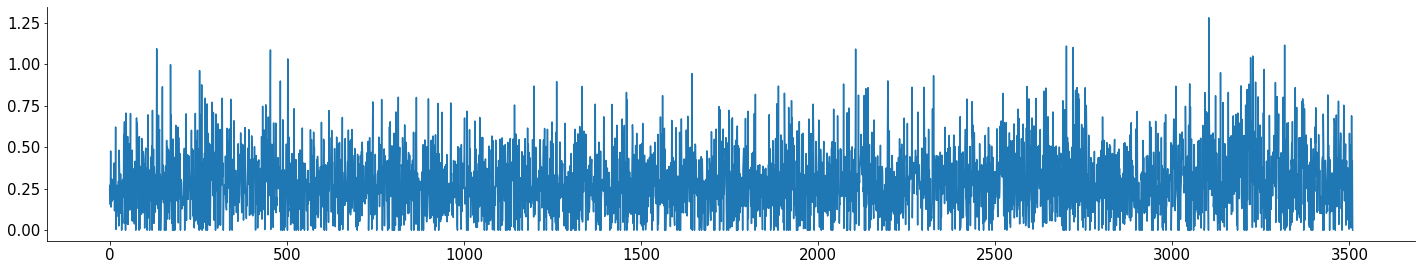

In [11]:
plt.plot(data_layer0[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = data_layer0.shape[0]

In [15]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = NN 
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(data_layer0[:,:int(frac*data_layer0.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(data_layer0[:,:int(frac*data_layer0.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(data_layer0[:,int(frac*data_layer0.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(data_layer0[:,int(frac*data_layer0.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [16]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, num_layers = 1, n_comp = 50, dropout= 0,  bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = num_layers, dropout = dropout,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [17]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'num_layers': {
        'values': [1, 2, 3]
        },
    'n_comp': {
        'values': [50, 75, 100, 125, 150]
        },
    
    'dropout': {
          'values': [0.1, 0.2, 0.3, 0.5]
        },
    'weight_decay': {
          'values': [0., 1e-5, 5e-5, 1e-6]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 3000}
    })

import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform',
        'min': -9.9,
        'max': -5.3
    },
})

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.1, 0.2, 0.3, 0.5]},
                'epochs': {'value': 3000},
                'learning_rate': {'distribution': 'log_uniform',
                                  'max': -5.3,
                                  'min': -9.9},
                'n_comp': {'values': [50, 75, 100, 125, 150]},
                'num_layers': {'values': [1, 2, 3]},
                'optimizer': {'values': ['adam']},
                'weight_decay': {'values': [0.0, 1e-05, 5e-05, 1e-06]}}}


In [18]:
sweep_id = wandb.sweep(sweep_config, project="NMAs-XY-Layout-HyperOpt")

Create sweep with ID: bt5cfqya
Sweep URL: https://wandb.ai/sazio/NMAs-XY-Layout-HyperOpt/sweeps/bt5cfqya


In [19]:
# you can keep re-running this cell if you think the cost might decrease further
cost = nn.MSELoss()

# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370

## Training 

In [20]:
from tqdm import tqdm

In [21]:
def build_optimizer(network, optimizer, learning_rate, weight_decay): 
    optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        # loader = build_dataset(config.batch_size)
        # Net(ncomp, NN1, NN2, bidi = True).to(device)
        network = Net(ncomp, NN1, NN2, config.num_layers, config.dropout).to(device)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.weight_decay)

        for epoch in range(config.epochs):
            # avg_loss = train_epoch(network, loader, optimizer)
            network.train()
            # the networkwork outputs the single-neuron prediction and the latents
            z, y = network(x1_train)

            # our cost
            loss = cost(z, x2_train)

            # train the networkwork as usual
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                network.eval()
                valid_loss = cost(network(x1_valid)[0], x2_valid)

            if epoch % 50 == 0:
                with torch.no_grad():
                    network.eval()
                    valid_loss = cost(network(x1_valid)[0], x2_valid)
                    
                    print(f' iteration {epoch}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')
            wandb.log({"train_loss": loss.item(), 'valid_loss': valid_loss.item(), "epoch": epoch})

In [22]:
wandb.agent(sweep_id, train, count= 50)

wandb: Agent Starting Run: hwhnoxb8 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 3000
wandb: 	learning_rate: 7.99766743376858e-05
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.6973, valid cost 5.3905
 iteration 50, train cost 4.2301, valid cost 4.8607
 iteration 100, train cost 3.3311, valid cost 3.8515
 iteration 150, train cost 3.0034, valid cost 3.4842
 iteration 200, train cost 2.9078, valid cost 3.3796
 iteration 250, train cost 2.8708, valid cost 3.3409
 iteration 300, train cost 2.8560, valid cost 3.3259
 iteration 350, train cost 2.8469, valid cost 3.3176
 iteration 400, train cost 2.8390, valid cost 3.3099
 iteration 450, train cost 2.8295, valid cost 3.2997
 iteration 500, train cost 2.8160, valid cost 3.2854
 iteration 550, train cost 2.7954, valid cost 3.2627
 iteration 600, train cost 2.7640, valid cost 3.2291
 iteration 650, train cost 2.7297, valid cost 3.1927
 iteration 700, train cost 2.7021, valid cost 3.1634
 iteration 750, train cost 2.6800, valid cost 3.1372
 iteration 800, train cost 2.6584, valid cost 3.1065
 iteration 850, train cost 2.6317, valid cost 3.0668
 iteration 900, train cost 2.6037, valid cost 3.0

wandb: Ctrl + C detected. Stopping sweep.
